In [2]:
from src.tensor import Tensor
import src.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mnist import MNIST
np.set_printoptions(suppress=True)

In [3]:
mndata = MNIST('./mnist_dataset/')
mndata.gz = True
training, test = mndata.load_training(), mndata.load_testing()

In [4]:
X = np.array(training[0] + test[0], dtype=float)
Y = np.array(list(training[1]) + list(test[1]), dtype=int)

# Scale down pixels from 0-255 to 0-1
X = X / 255.0

# OneHot label vectors
one_hot = np.zeros((Y.size, 10)) # (70000, 10)
one_hot[np.arange(Y.size), Y] = 1
Y = one_hot

In [5]:
# Split
n = len(X)
tr, d = int(n*0.8), int(n*0.9)
Xtr, Xdev, Xte = Tensor(X[:tr]), Tensor(X[tr:d]), Tensor(X[d:])
Ytr, Ydev, Yte = Tensor(Y[:tr]), Tensor(Y[tr:d]), Tensor(Y[d:])
print(f'Sizes: train={len(Xtr)}, val={len(Xdev)}, test={len(Xte)}')

Sizes: train=56000, val=7000, test=7000


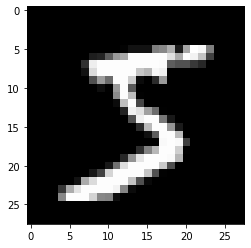

In [6]:
# Visualize X
img = np.array(Xtr[0].tolist())
plt.imshow(img.reshape(28, 28),cmap='gray')
plt.show()

In [7]:
# Multinomial sampling with replacement
rng = np.random.default_rng(seed=1)
def draw_batch(batch_size): 
    draw = lambda: int(rng.random() * len(Xtr))
    batch = [draw() for _ in range(batch_size)]
    return Xtr[batch], Ytr[batch]

def accuracy(split):
    x, y = {'train': (Xtr, Ytr), 'dev': (Xdev, Ydev), 'test': (Xte, Yte)}[split]
    global mlp
    x = mlp(x) # (7000, 10)
    correct = (x.data.argmax(1) == y.data.argmax(1)).sum()
    acc = (correct / len(x)) * 100
    print(f'{split}-accuracy: {acc:.2f}%')

In [8]:
mlp = nn.Sequential((
    nn.Linear(784, 724, bias=False), nn.BatchNorm(724),
    nn.Tanh(),
    nn.Linear(724, 512, bias=False), nn.BatchNorm(512),
    nn.Tanh(),
    nn.Linear(512, 256, bias=False), nn.BatchNorm(256),
    nn.Tanh(),
    nn.Linear(256, 128, bias=False), nn.BatchNorm(128),
    nn.Tanh(),
    nn.Linear(128, 64, bias=False), nn.BatchNorm(64),
    nn.Tanh(),
    nn.Linear(64, 10, bias=False),
    nn.Softmax()
))
losses = []
dev_losses = []

Step 0: train=0.5954711192742712, val=0.6129727840994533
Step 1: train=0.8859258214436723, val=0.6135067257550099
Step 2: train=0.5118046956699358, val=0.613397617369046
Step 3: train=0.982016556419868, val=0.6128332899276725
Step 4: train=0.5120913716686795, val=0.6127815476174683
Step 5: train=0.574881333880511, val=0.612867670425873
Step 6: train=0.9411150823688725, val=0.6129042004965999
Step 7: train=0.548142367936194, val=0.6124749050413902
Step 8: train=0.33092675630369794, val=0.6121420323275482
Step 9: train=0.8504333669016675, val=0.6123610294918883
Step 10: train=1.090149342055287, val=0.6120998878803611
Step 11: train=0.48345349764399476, val=0.6122022902308012
Step 12: train=0.8396902251379827, val=0.6120535181666307
Step 13: train=0.7304851307990677, val=0.6117340275458499
Step 14: train=1.0516735743021788, val=0.6120810564451167
Step 15: train=0.460054352219783, val=0.6122763929152111
Step 16: train=0.8416282540369284, val=0.6116245816525959
Step 17: train=0.507636359680

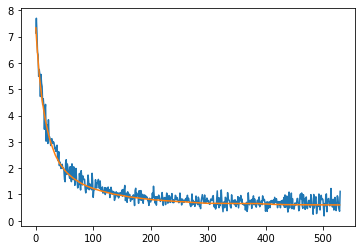

In [15]:
steps = 100
batch_size = 32
lr = 0.01
breakpoint = -1
for i in range(steps):
    x, y = draw_batch(batch_size)
    out = mlp(x)

    loss = nn.nlll(out, y, reduction='mean')
    loss.backward()

    mlp.optimize(lr=lr)
    mlp.zero_grad()

    loss = loss.data.item()
    losses.append(loss)
    dev_loss = nn.nlll(mlp(Xdev), Ydev, reduction='mean').data.item()
    dev_losses.append(dev_loss)
    print(f'Step {i}: train={loss}, val={dev_loss}')

plt.plot(losses, label='train')
plt.plot(dev_losses, label='dev')
plt.show()

In [16]:
accuracy('dev')

dev-accuracy: 81.09%


In [17]:
mlp.inference()
accuracy('test')

test-accuracy: 83.46%
